In [52]:
import numpy as np
import pandas as pd
import psycopg2
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from scipy import stats
import spotipy
from requests import post,get
import json
from spotipy.oauth2 import SpotifyClientCredentials
from functions import get_token,get_auth_header,search_for_artist,search_for_track
import warnings
warnings.filterwarnings("ignore")


In [2]:
CLIENT_ID="bbeade3ebc754cd0ae2721fe0df9132b"
CLIENT_SECRET="0c70e5c244d54820b83c7d853514cd53"

client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)


token=get_token()

In [3]:
f= open("password.txt",'r')
pssword=f.read()

conn=None
cur=None

conn = psycopg2.connect(
    database='dataproject',
    host="localhost",
    user="postgres",
    password=pssword,
    port=5432)

cur =conn.cursor()

In [4]:
# Fetching the total number of tracks
cur.execute('SELECT COUNT(*) id FROM track_rock;')
for row in cur:
    data_count = row
size=int(data_count[0])
print('Track size: ',size)

Track size:  5359


In [5]:
# Fetching data from multiple tables and processing it
cur.execute('''SELECT track_rock.track_name,artist_rock.popularity, artist_rock.genres, analyze_rock.* FROM track_rock
                    INNER JOIN artist_rock ON artist_rock.id=track_rock.artist_id
                    INNER JOIN analyze_rock ON analyze_rock.id=track_rock.id ''')
analyze_data= cur

In [6]:
# Initializing arrays to store fetched data
pops = np.zeros(size)
vector = np.zeros((size, 10))
ids = np.zeros(size, dtype='<U22')
genre = np.zeros(size, dtype='<U30')

In [7]:
for k, row in enumerate(analyze_data):
    # Storing popularity
    pops[k] = row[1]
    # Storing genre
    genre[k] = row[2]
    # Storing analysis vector
    vector[k] = row[4:]
    # Storing track IDs
    ids[k] = row[3]

#### Feature Engineering

In [8]:
# Preprocess genre data
dgenre = pd.DataFrame(genre, columns=['genre'])
encoder = OrdinalEncoder()
dgenre['genre'] = encoder.fit_transform(dgenre[['genre']])

In [9]:
# Combine vector and genre data
dvector = pd.DataFrame(vector, columns=['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence'])
danalyze = dvector

In [10]:
# Data transformation and diagnostics
danalyze['acousticness'] = np.log(danalyze['acousticness'])
danalyze['liveness'] = np.log(danalyze['liveness'])
danalyze['speechiness'] = 1 / danalyze['speechiness']
danalyze['tempo'] = np.sqrt(danalyze['tempo'])

Transformation of the data makes the distributions gaussian like, so this process enhanced the recommendation mechanism.

In [11]:
# Remove outliers
danalyze['loudness'] = danalyze['loudness'].clip(lower=danalyze['loudness'].quantile(0.01), upper=danalyze['loudness'].quantile(0.99))

## Visualization

### Visualization of Sound Analysis Vector

In [12]:
# Data diagnostics plots
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.title(f'Histogram of {variable}')
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.title(f'Q-Q plot of {variable}')
    plt.savefig(f'Plots/{variable}.png')
    plt.show()

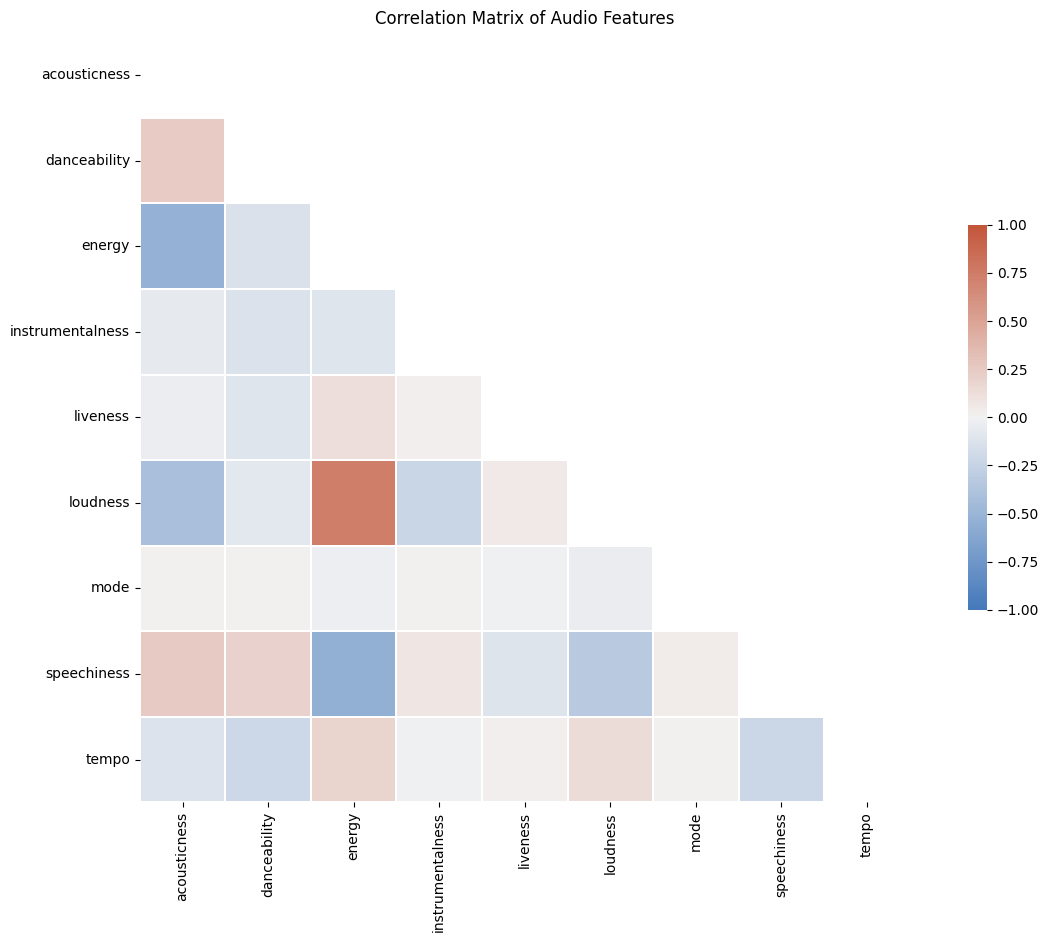

In [13]:
# Compute the correlation matrix
corr = danalyze.iloc[:,:-1].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.2, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix of Audio Features')
plt.savefig(f'Plots/Correlation Matrix of Audio Features.png')
plt.show()

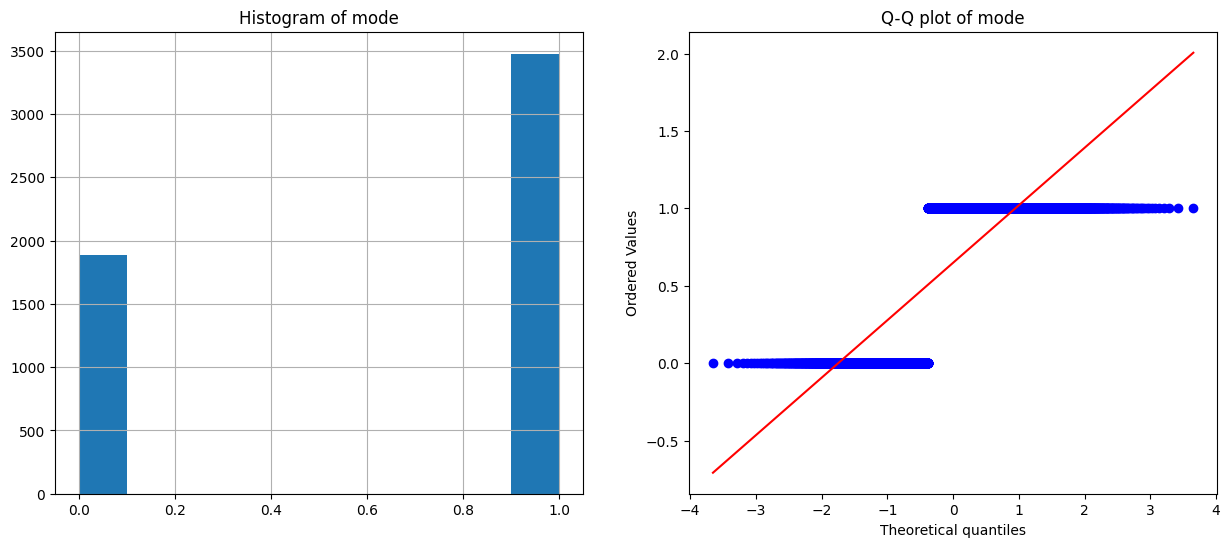

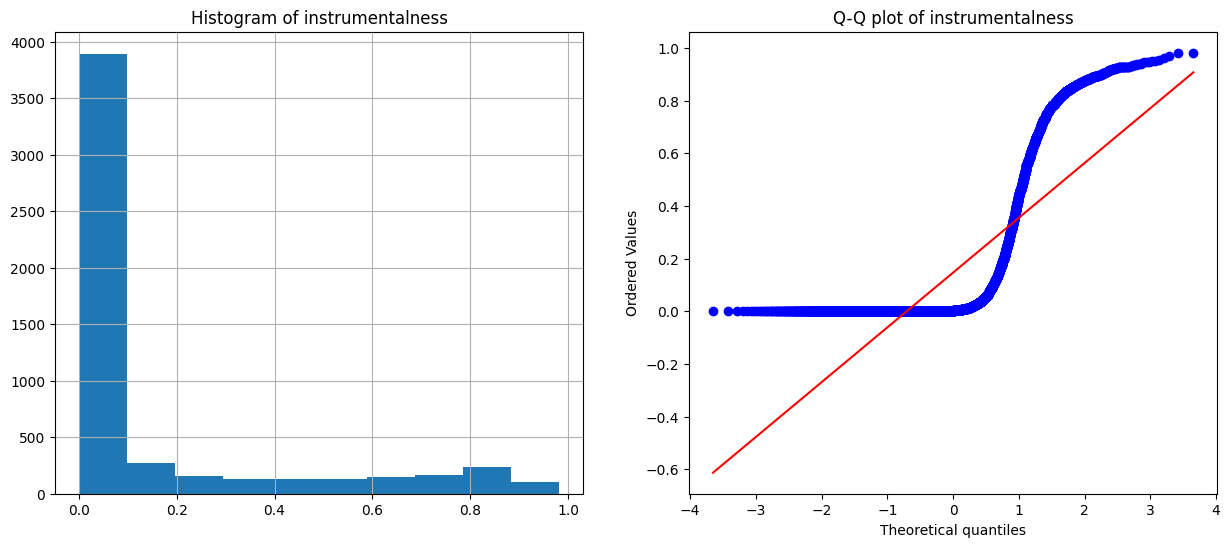

In [14]:
# Plot histograms and Q-Q plots for removed columns
removed_columns = ['mode', 'instrumentalness']
for col in removed_columns:
    diagnostic_plots(danalyze, col)

These variables are unlikely to make a great contribution to recommendation mechanism. Therefore, I decided to remove them.

In [15]:
# Remove unnecessary columns
danalyze.drop(['mode', 'instrumentalness'], axis=1, inplace=True)

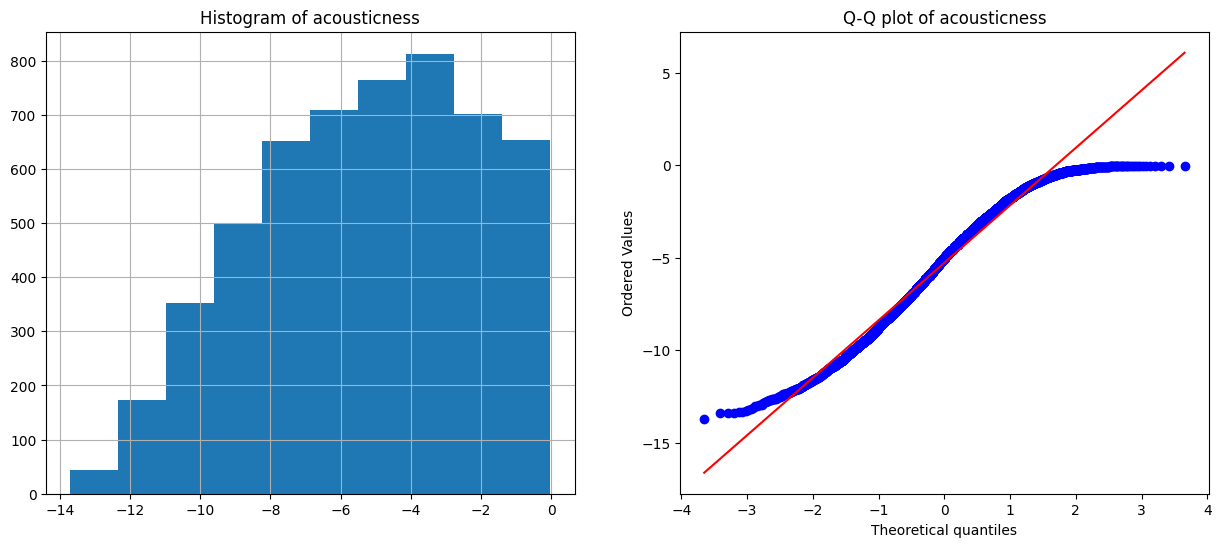

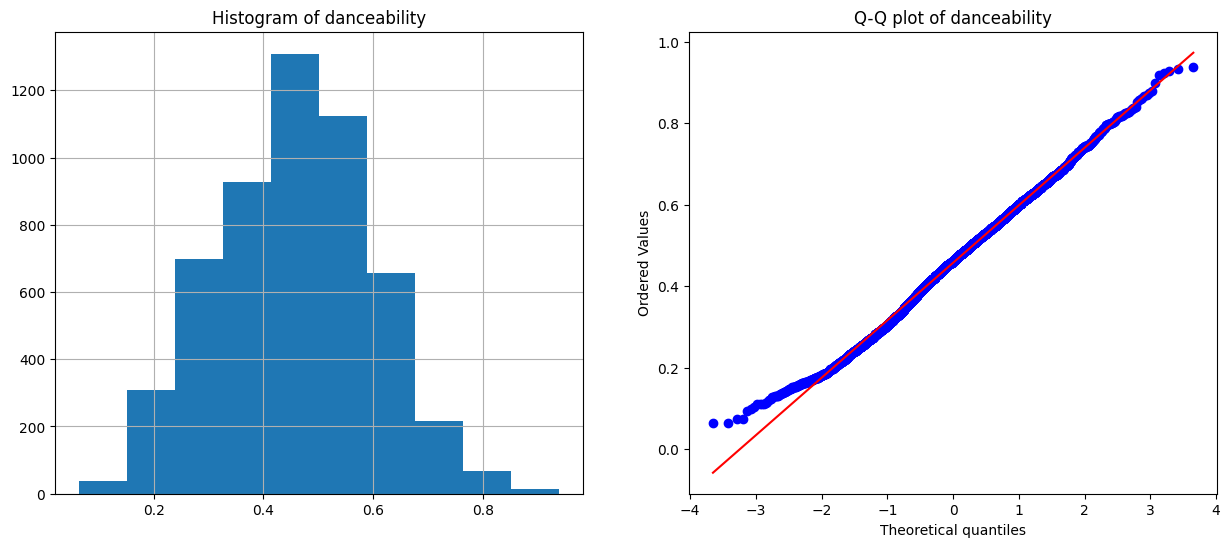

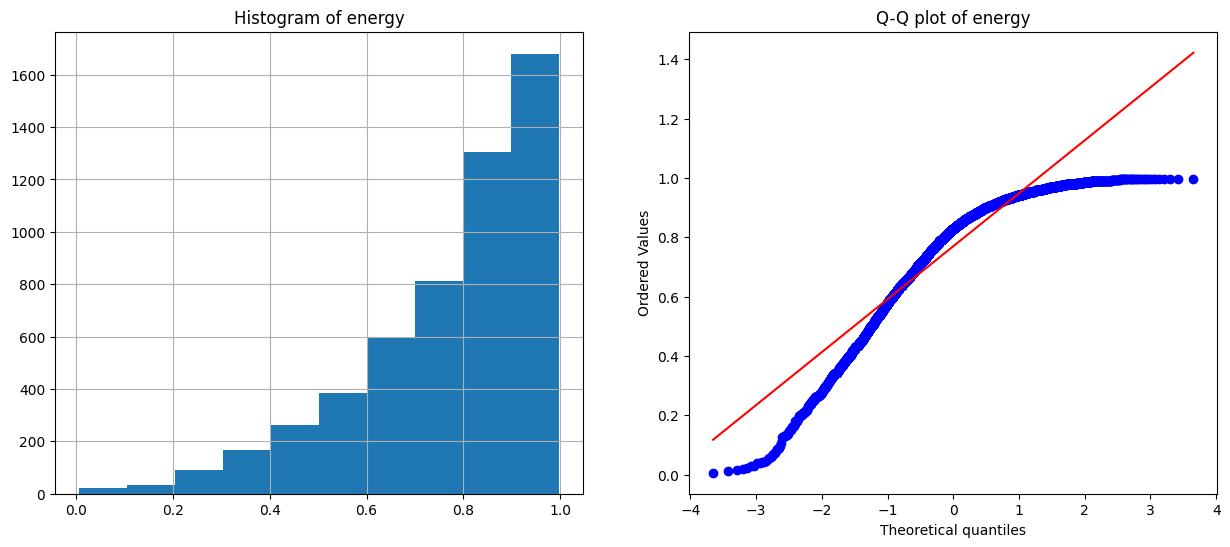

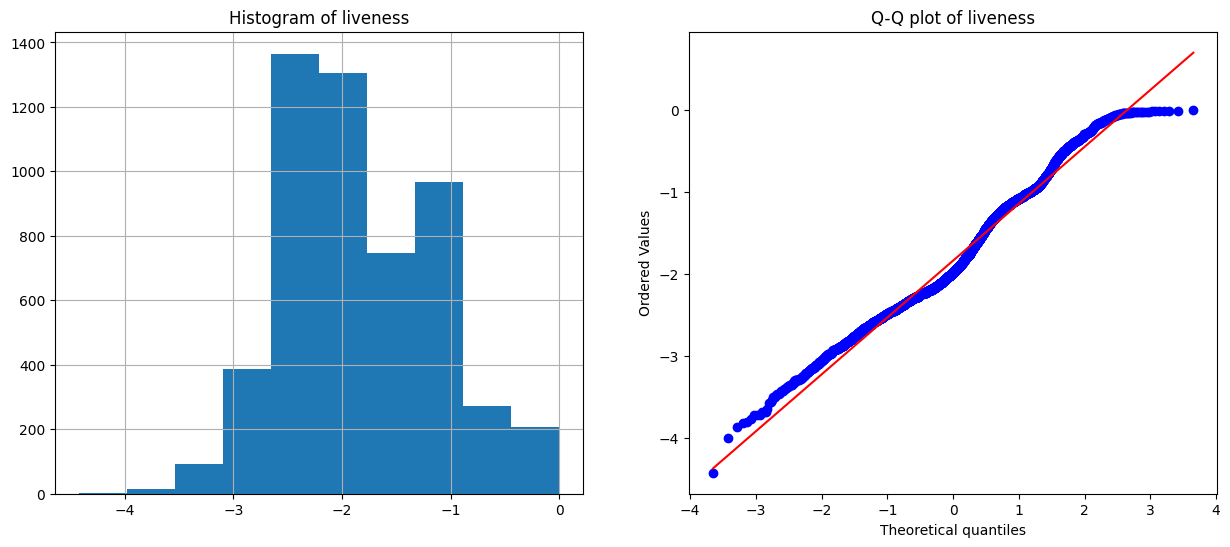

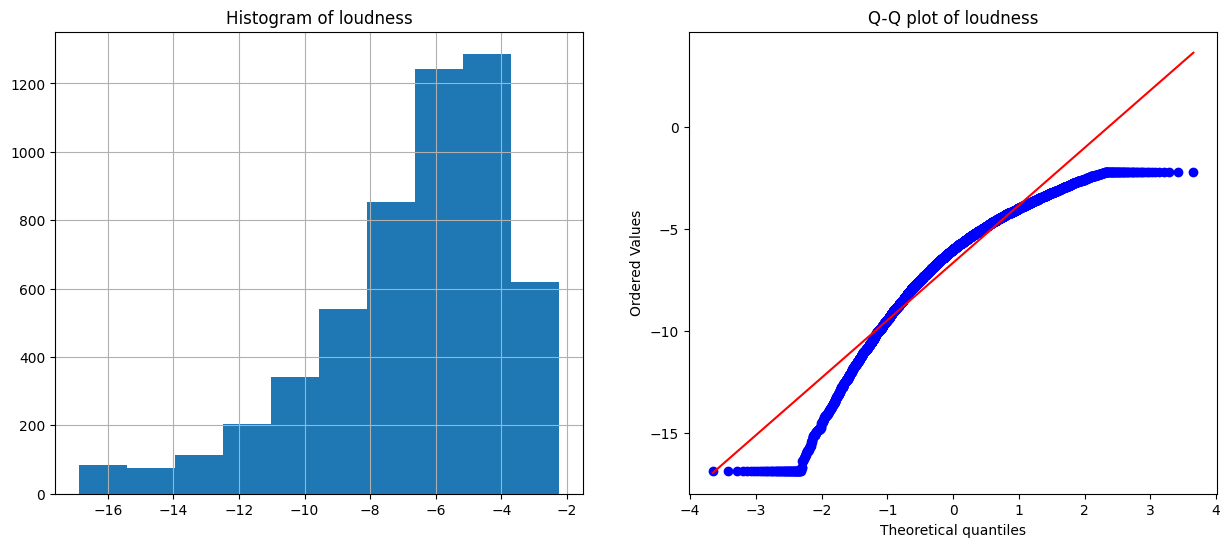

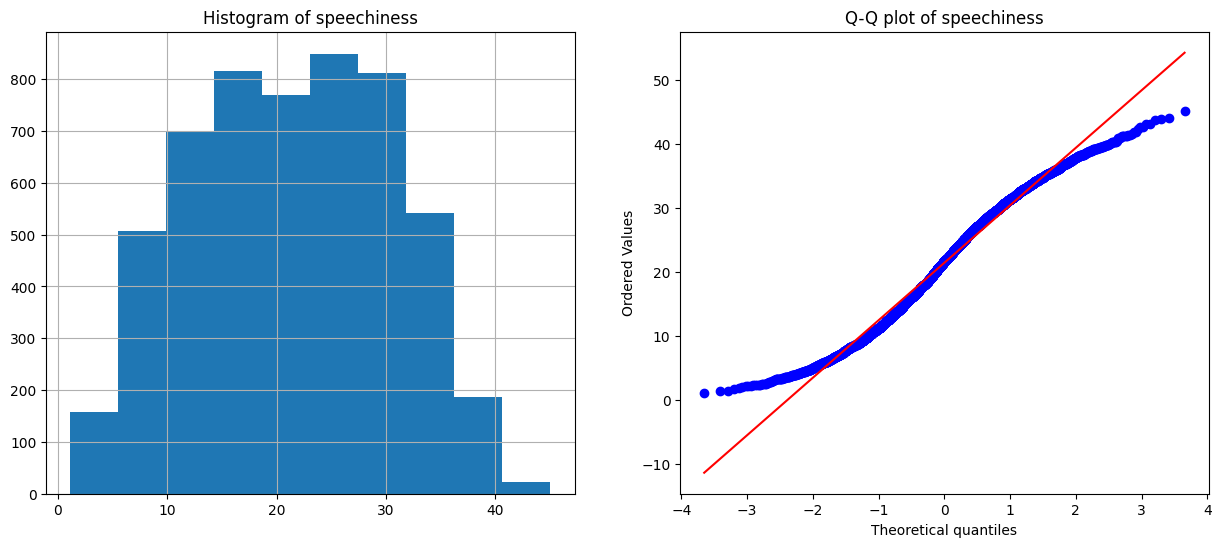

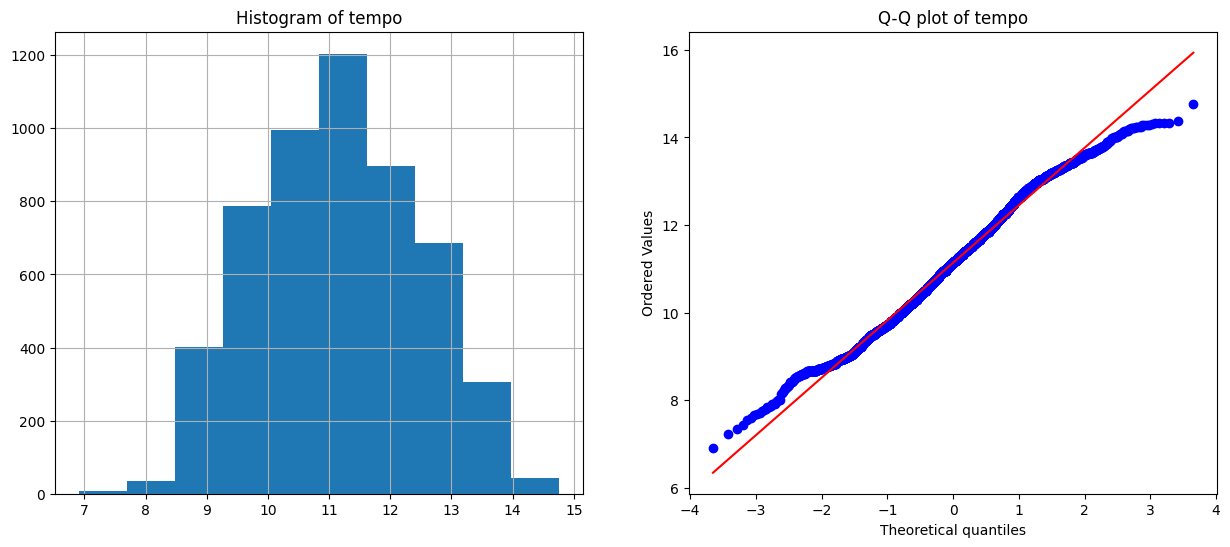

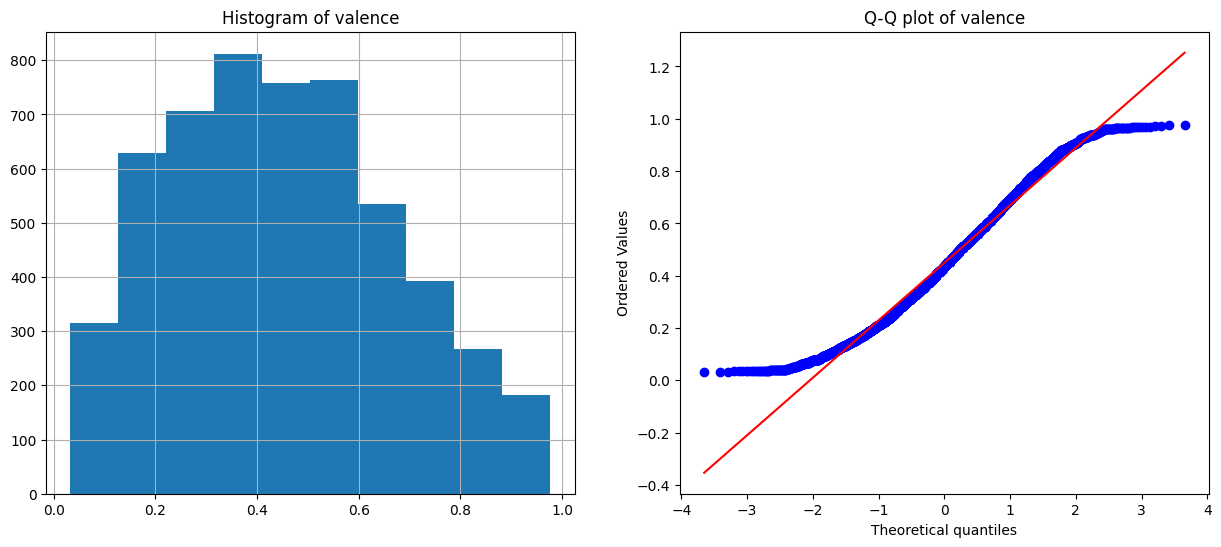

In [16]:
for col in danalyze.columns:
    diagnostic_plots(danalyze, col)

### Top 50 Popular Songs

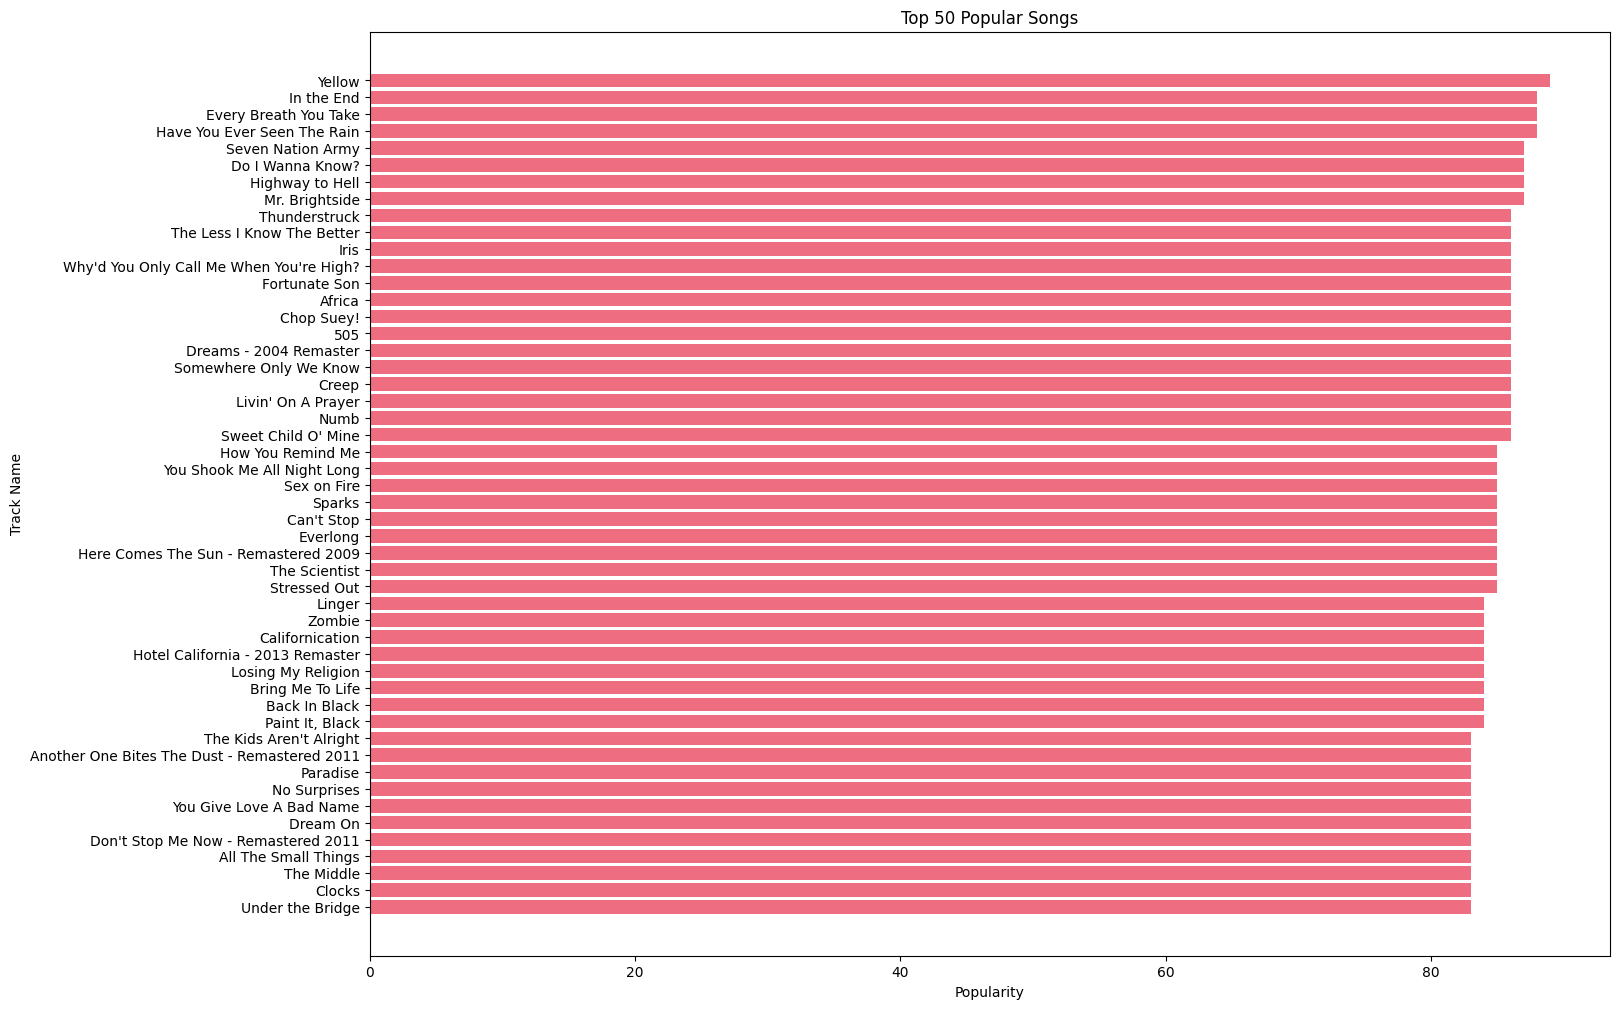

In [17]:
# Execute SQL query
cur.execute("SELECT track_name, popularity FROM track_rock ORDER BY popularity DESC LIMIT 50;")
data = cur.fetchall()

# Convert data to Pandas DataFrame
df = pd.DataFrame(data, columns=['Track Name', 'Popularity'])

# Visualize top 50 popular songs
plt.figure(figsize=(16, 12))
plt.barh(df['Track Name'], df['Popularity'], color='#ef6d80')
plt.xlabel('Popularity')
plt.ylabel('Track Name')
plt.title('Top 50 Popular Songs')
plt.gca().invert_yaxis() 
plt.savefig('Plots/Top 50 Popular Songs.png')
plt.show()

In [18]:
# Execute SQL query
cur.execute("""
    SELECT track_rock.track_name, artist_rock.artist_name, track_rock.popularity
    FROM track_rock
    INNER JOIN artist_rock ON artist_rock.id = track_rock.artist_id
    ORDER BY track_rock.popularity DESC
    LIMIT 5;
""")
popular_songs = cur.fetchall()

# Print most popular 5 songs with artists
print("Most Popular 5 Songs:")
for song in popular_songs:
    print(f"{song[0]} by {song[1]} (Popularity: {song[2]})")


Most Popular 5 Songs:
Yellow by Coldplay (Popularity: 89)
Every Breath You Take by The Police (Popularity: 88)
In the End by Linkin Park (Popularity: 88)
Have You Ever Seen The Rain by Creedence Clearwater Revival (Popularity: 88)
Do I Wanna Know? by Arctic Monkeys (Popularity: 87)


### Most Frequent Artists

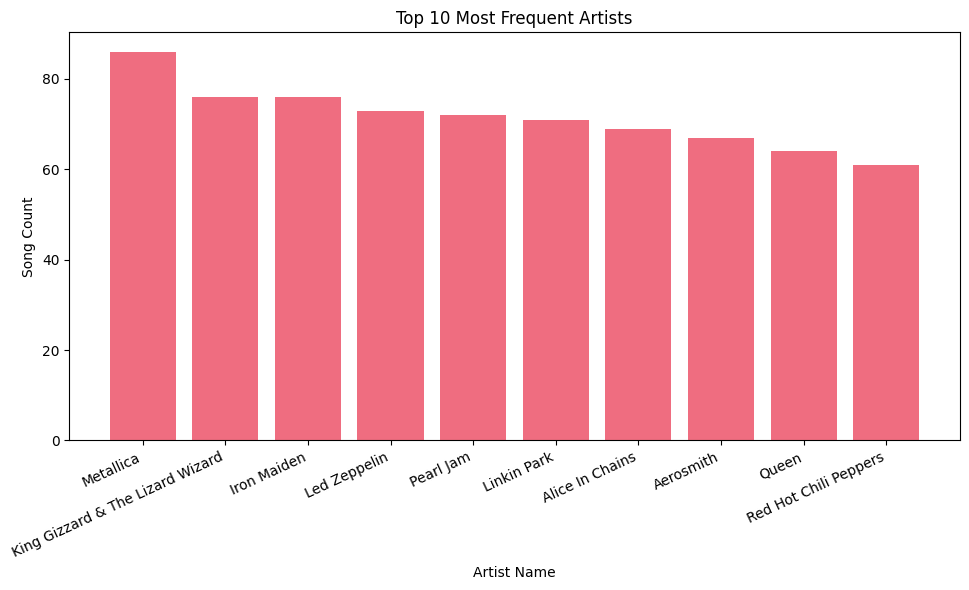

In [19]:
# Execute SQL query
cur.execute("SELECT artist_name, COUNT(*) AS song_count FROM artist_rock JOIN track_rock ON artist_rock.id = track_rock.artist_id GROUP BY artist_name ORDER BY song_count DESC LIMIT 10;")
data = cur.fetchall()

# Convert data to DataFrame
df = pd.DataFrame(data, columns=['Artist Name', 'Song Count'])

# Visualize most frequent artists
plt.figure(figsize=(10, 6))
plt.bar(df['Artist Name'], df['Song Count'], color='#ef6d80')
plt.xlabel('Artist Name')
plt.ylabel('Song Count')
plt.title('Top 10 Most Frequent Artists')
plt.xticks(rotation=25, ha='right')  
plt.tight_layout()
plt.savefig('Plots/Top 10 Most Frequent Artists.png')
plt.show()

### Top 10 Most Frequent Genres

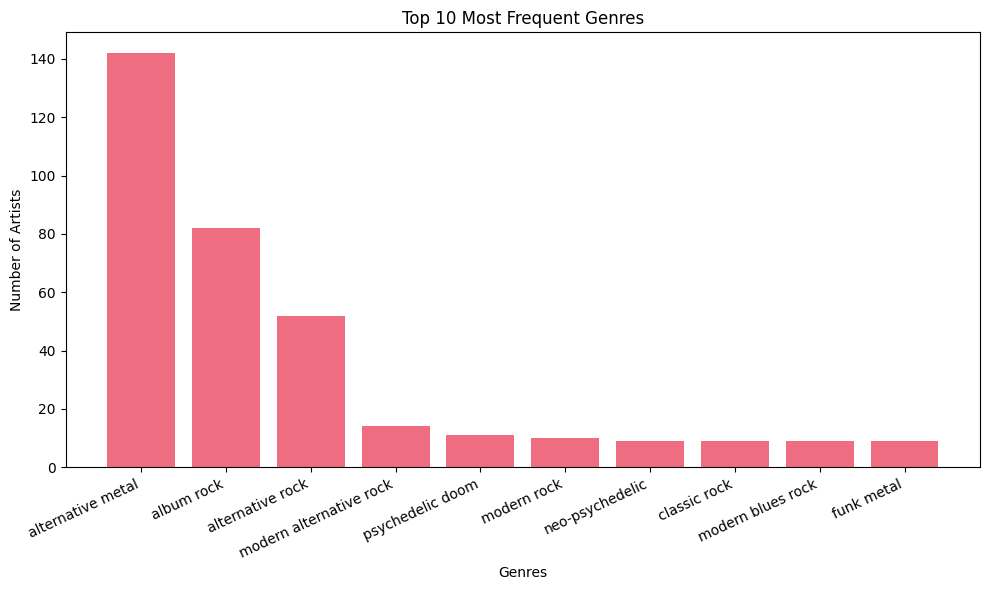

In [20]:
# Execute SQL query
cur.execute("""
    SELECT genres, COUNT(*) AS artist_count
    FROM artist_rock
    WHERE genres <> ''
    GROUP BY genres
    ORDER BY artist_count DESC
    LIMIT 10;
""")
data = cur.fetchall()

# Convert data to DataFrame
df = pd.DataFrame(data, columns=['Genres', 'Artist Count'])

# Visualize top 10 genre distribution
plt.figure(figsize=(10, 6)) 
plt.bar(df['Genres'], df['Artist Count'], color='#ef6d80')
plt.xlabel('Genres')
plt.ylabel('Number of Artists')
plt.title('Top 10 Most Frequent Genres')
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.savefig('Plots/Top 10 Most Frequent Genres.png')
plt.show()

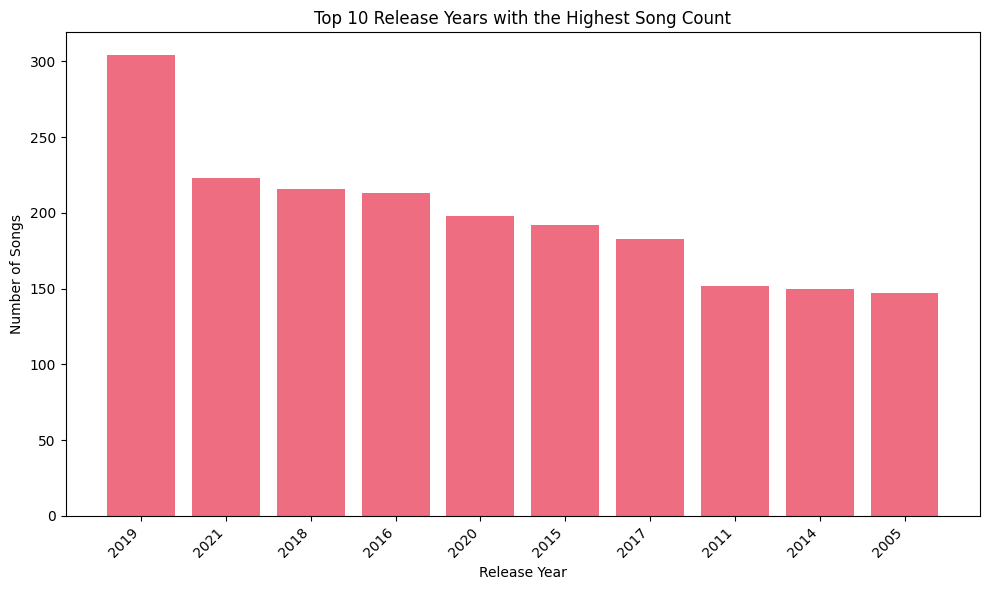

In [21]:
# Execute SQL query
cur.execute("""
    SELECT SUBSTRING(a.release_date, 1, 4) AS release_year, COUNT(*) AS song_count
    FROM album_rock a
    JOIN track_rock t ON a.id = t.album_id
    GROUP BY SUBSTRING(a.release_date, 1, 4)
    ORDER BY song_count DESC
    LIMIT 10;
""")
data = cur.fetchall()


# Convert data to DataFrame
df = pd.DataFrame(data, columns=['Release Year', 'Song Count'])

# Visualize top 10 release years with the highest song count
plt.figure(figsize=(10, 6))
plt.bar(df['Release Year'], df['Song Count'], color='#ef6d80')
plt.xlabel('Release Year')
plt.ylabel('Number of Songs')
plt.title('Top 10 Release Years with the Highest Song Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Plots/Top 10 Release Years with the Highest Song Count.png')
plt.show()

I'd like to emphasize that this years probably show misinformation because of remastered versions of the albums.

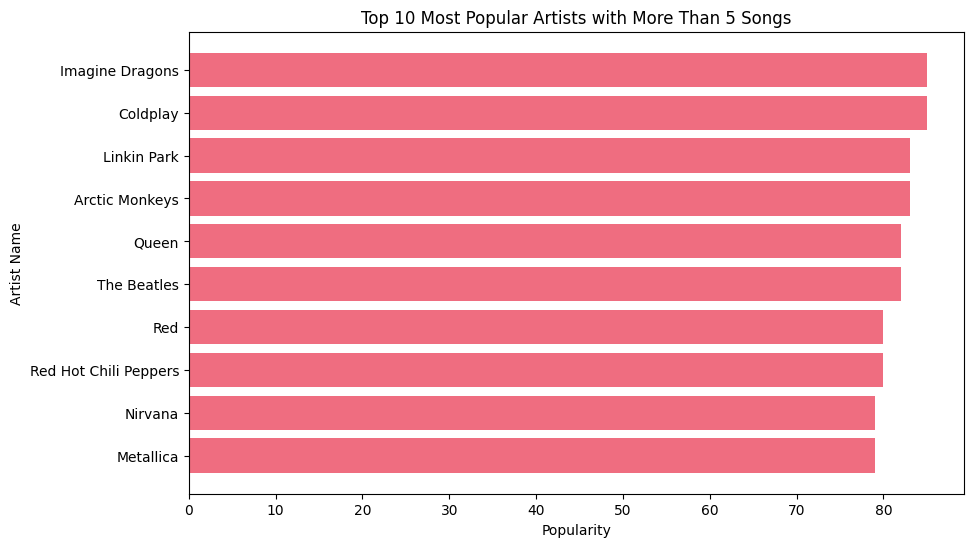

In [22]:
# Execute SQL query
cur.execute("""
    SELECT artist_rock.artist_name, artist_rock.popularity, COUNT(track_rock.track_name) AS song_count
    FROM artist_rock 
    JOIN track_rock ON artist_rock.id = track_rock.artist_id
    GROUP BY artist_rock.artist_name, artist_rock.popularity
    HAVING COUNT(track_rock.track_name) > 5
    ORDER BY artist_rock.popularity DESC
    LIMIT 10;
""")
data = cur.fetchall()


# Convert data to DataFrame
df = pd.DataFrame(data, columns=['Artist Name', 'Popularity', 'Song Count'])

# Visualize top 10 most popular artists with more than 5 songs
plt.figure(figsize=(10, 6))
plt.barh(df['Artist Name'], df['Popularity'], color='#ef6d80')
plt.xlabel('Popularity')
plt.ylabel('Artist Name')
plt.title('Top 10 Most Popular Artists with More Than 5 Songs')
plt.gca().invert_yaxis()
plt.savefig('Plots/Top 10 Most Popular Artists with More Than 5 Songs.png')
plt.show()


Since there may be artists from different genres who entered the data with a low number of songs, the 10 most popular artists with more than 5 songs in the database were visualized.

### Track Audio Analysis

### Top and Least Tracks by Tempo

In [23]:
def plot_top_tracks_by_feature(feature):
    # Execute SQL query
    cur.execute(f"""
        SELECT track_rock.track_name, analyze_rock.{feature}, artist_rock.artist_name
        FROM analyze_rock
        JOIN track_rock ON analyze_rock.id = track_rock.id
        JOIN artist_rock ON track_rock.artist_id = artist_rock.id
        ORDER BY analyze_rock.{feature} DESC
        LIMIT 10;
    """)
    data = cur.fetchall()

    # Convert data to DataFrame
    df_top_tracks = pd.DataFrame(data, columns=['Track Name', feature.capitalize(), 'Artist Name'])

    # Plot the top tracks based on the given feature
    plt.figure(figsize=(10, 6))
    plt.barh(df_top_tracks['Track Name'], df_top_tracks[feature.capitalize()], color='#ef6d80')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Track Name')
    plt.title(f'Top 10 Tracks by {feature.capitalize()}')
    plt.gca().invert_yaxis()
    plt.savefig(f'Plots/Top 10 Tracks by {feature.capitalize()}.png')
    plt.show()

    # Print the top tracks with artist names and feature values
    for i, row in df_top_tracks.iterrows():
        print(f"{row['Track Name']} by {row['Artist Name']} - {feature.capitalize()}: {row[feature]}")


In [24]:
def plot_least_tracks_by_feature(feature):
    # Execute SQL query
    cur.execute(f"""
        SELECT track_rock.track_name, analyze_rock.{feature}, artist_rock.artist_name
        FROM analyze_rock
        JOIN track_rock ON analyze_rock.id = track_rock.id
        JOIN artist_rock ON track_rock.artist_id = artist_rock.id
        ORDER BY analyze_rock.{feature} ASC
        LIMIT 10;
    """)
    data = cur.fetchall()

    # Convert data to DataFrame
    df_top_tracks = pd.DataFrame(data, columns=['Track Name', feature.capitalize(), 'Artist Name'])

    # Plot the top tracks based on the given feature
    plt.figure(figsize=(10, 6))
    plt.barh(df_top_tracks['Track Name'], df_top_tracks[feature.capitalize()], color='#ef6d80')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Track Name')
    plt.title(f'Least 10 Tracks by {feature.capitalize()}')
    plt.gca().invert_yaxis()
    plt.savefig(f'Plots/Least 10 Tracks by {feature.capitalize()}.png')
    plt.show()

    # Print the top tracks with artist names and feature values
    for i, row in df_top_tracks.iterrows():
        print(f"{row['Track Name']} by {row['Artist Name']} - {feature.capitalize()}: {row[feature]}")


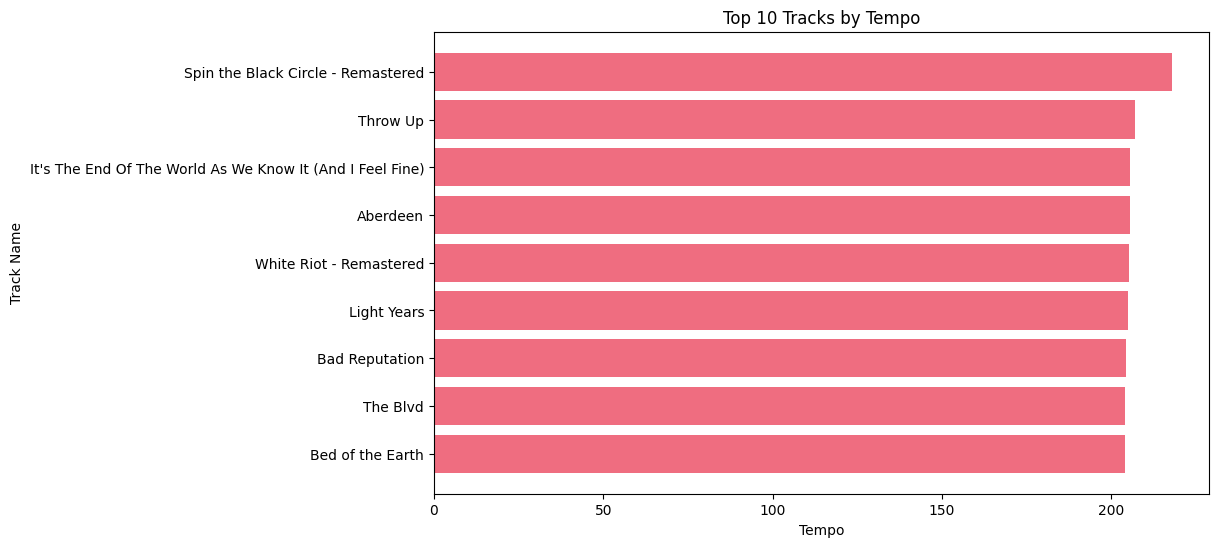

Spin the Black Circle - Remastered by Pearl Jam - Tempo: 217.913
Throw Up by Red Fang - Tempo: 206.909
It's The End Of The World As We Know It (And I Feel Fine) by R.E.M. - Tempo: 205.528
Aberdeen by Cage The Elephant - Tempo: 205.478
White Riot - Remastered by The Clash - Tempo: 205.278
Light Years by Pearl Jam - Tempo: 205.07
Light Years by Pearl Jam - Tempo: 204.586
Bad Reputation by Joan Jett & the Blackhearts - Tempo: 204.335
The Blvd by John Garcia - Tempo: 204.149
Bed of the Earth by Holy Monitor - Tempo: 203.983


In [25]:
plot_top_tracks_by_feature('Tempo')

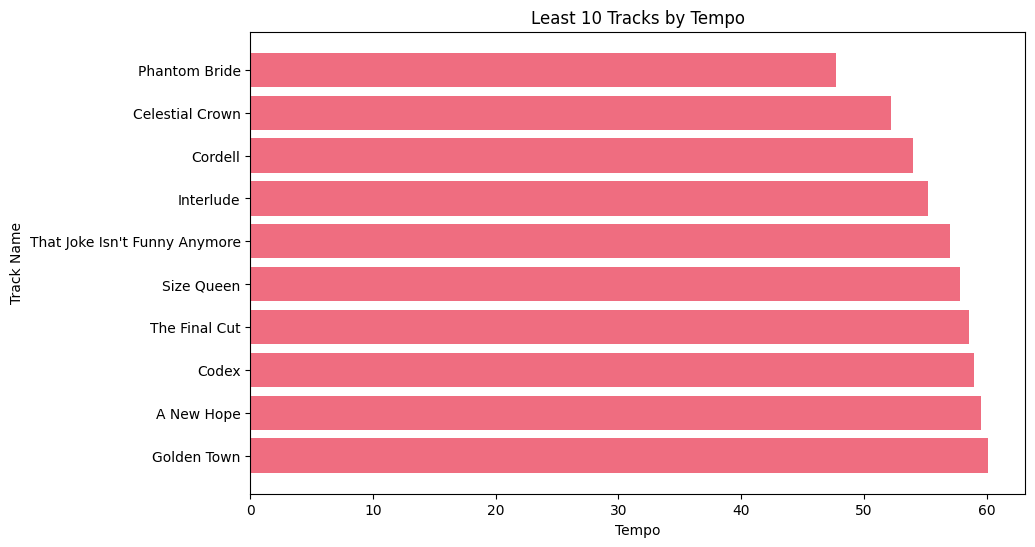

Phantom Bride by Deftones - Tempo: 47.73
Celestial Crown by The Sword - Tempo: 52.217
Cordell by The Cranberries - Tempo: 54.029
Interlude by Muse - Tempo: 55.227
That Joke Isn't Funny Anymore by The Smiths - Tempo: 57.02
Size Queen by Kyuss - Tempo: 57.809
The Final Cut by Pink Floyd - Tempo: 58.588
Codex by Radiohead - Tempo: 58.996
A New Hope by Broken Iris - Tempo: 59.522
Golden Town by Brutus - Tempo: 60.151


In [26]:
plot_least_tracks_by_feature('Tempo')

### Top and Least Tracks by Acousticness

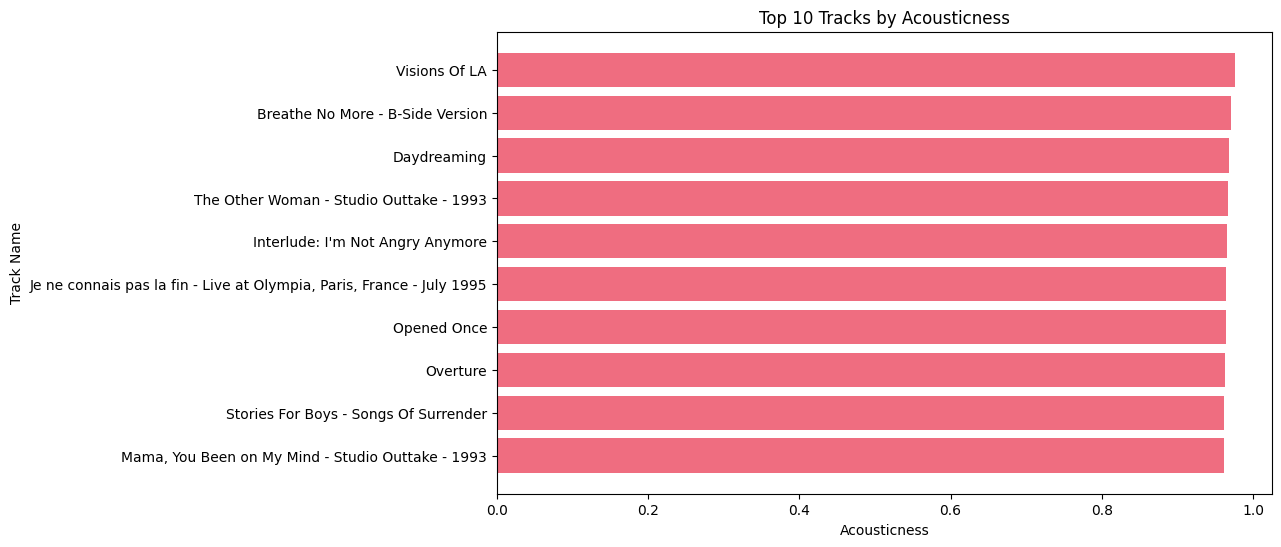

Visions Of LA by Slowdive - Acousticness: 0.976
Breathe No More - B-Side Version by Evanescence - Acousticness: 0.971
Daydreaming by Radiohead - Acousticness: 0.968
The Other Woman - Studio Outtake - 1993 by Jeff Buckley - Acousticness: 0.967
Interlude: I'm Not Angry Anymore by Paramore - Acousticness: 0.965
Je ne connais pas la fin - Live at Olympia, Paris, France - July 1995 by Jeff Buckley - Acousticness: 0.964
Opened Once by Jeff Buckley - Acousticness: 0.964
Overture by Evanescence - Acousticness: 0.963
Stories For Boys - Songs Of Surrender by U2 - Acousticness: 0.962
Mama, You Been on My Mind - Studio Outtake - 1993 by Jeff Buckley - Acousticness: 0.962


In [27]:
plot_top_tracks_by_feature('Acousticness')

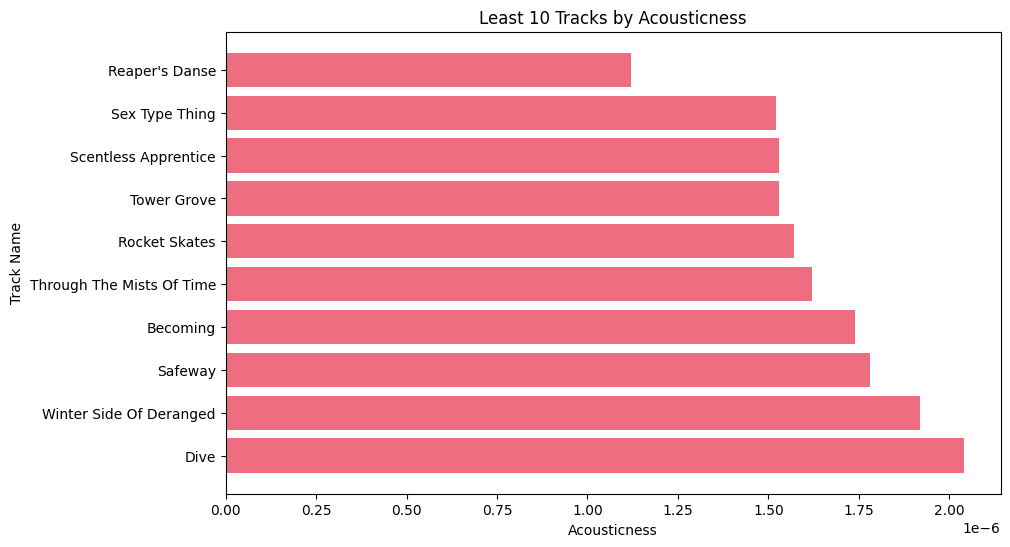

Reaper's Danse by Scorpion Child - Acousticness: 1.12e-06
Sex Type Thing by Stone Temple Pilots - Acousticness: 1.52e-06
Scentless Apprentice by Nirvana - Acousticness: 1.53e-06
Tower Grove by Scorpion Child - Acousticness: 1.53e-06
Rocket Skates by Deftones - Acousticness: 1.57e-06
Through The Mists Of Time by AC/DC - Acousticness: 1.62e-06
Becoming by Volbeat - Acousticness: 1.74e-06
Safeway by Feersum Ennjin - Acousticness: 1.78e-06
Winter Side Of Deranged by Scorpion Child - Acousticness: 1.92e-06
Dive by Nirvana - Acousticness: 2.04e-06


In [28]:
plot_least_tracks_by_feature('Acousticness')

### Top and Least Tracks by Danceability

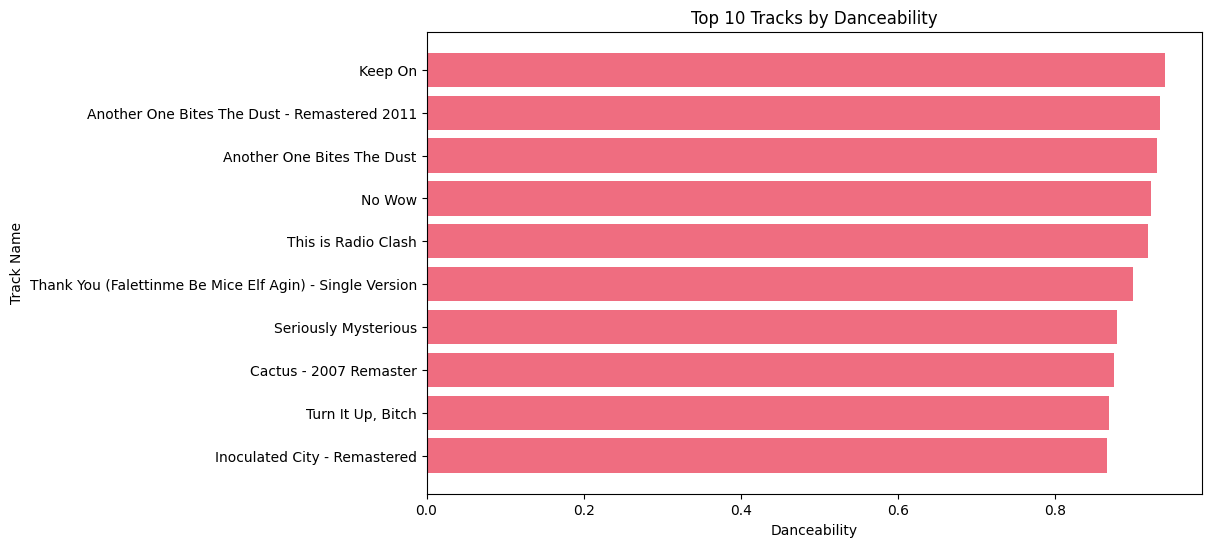

Keep On by Jackie Venson - Danceability: 0.939
Another One Bites The Dust - Remastered 2011 by Queen - Danceability: 0.933
Another One Bites The Dust by Queen - Danceability: 0.929
No Wow by The Kills - Danceability: 0.922
This is Radio Clash by The Clash - Danceability: 0.918
Thank You (Falettinme Be Mice Elf Agin) - Single Version by Sly & The Family Stone - Danceability: 0.899
Seriously Mysterious by The Sword - Danceability: 0.878
Cactus - 2007 Remaster by Pixies - Danceability: 0.874
Turn It Up, Bitch by Limp Bizkit - Danceability: 0.868
Inoculated City - Remastered by The Clash - Danceability: 0.866


In [29]:
plot_top_tracks_by_feature('Danceability')

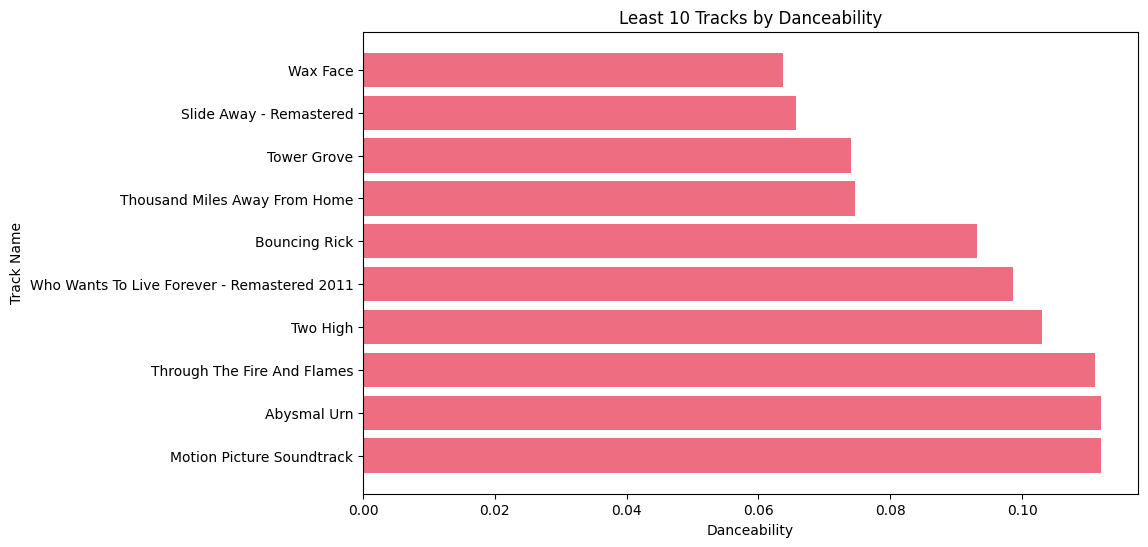

Wax Face by Thee Oh Sees - Danceability: 0.0638
Slide Away - Remastered by Oasis - Danceability: 0.0657
Tower Grove by Scorpion Child - Danceability: 0.0741
Thousand Miles Away From Home by Kadavar - Danceability: 0.0747
Bouncing Rick by Melvins - Danceability: 0.0931
Who Wants To Live Forever - Remastered 2011 by Queen - Danceability: 0.0986
Two High by Red Fang - Danceability: 0.103
Through The Fire And Flames by DragonForce - Danceability: 0.111
Abysmal Urn by Thee Oh Sees - Danceability: 0.112
Motion Picture Soundtrack by Radiohead - Danceability: 0.112


In [30]:
plot_least_tracks_by_feature('Danceability')

### Top and Least Tracks by Energy

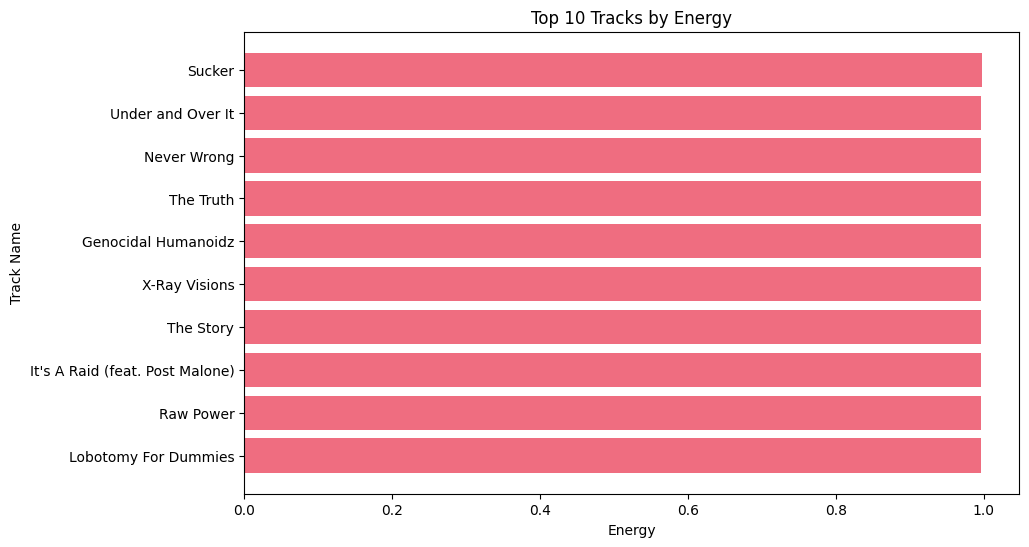

Sucker by Motörhead - Energy: 0.998
Under and Over It by Five Finger Death Punch - Energy: 0.996
Never Wrong by Disturbed - Energy: 0.996
The Truth by Limp Bizkit - Energy: 0.996
Genocidal Humanoidz by System Of A Down - Energy: 0.996
X-Ray Visions by Clutch - Energy: 0.996
The Story by Limp Bizkit - Energy: 0.996
It's A Raid (feat. Post Malone) by Ozzy Osbourne - Energy: 0.996
Raw Power by Guns N' Roses - Energy: 0.996
Lobotomy For Dummies by zebrahead - Energy: 0.996


In [31]:
plot_top_tracks_by_feature('Energy')

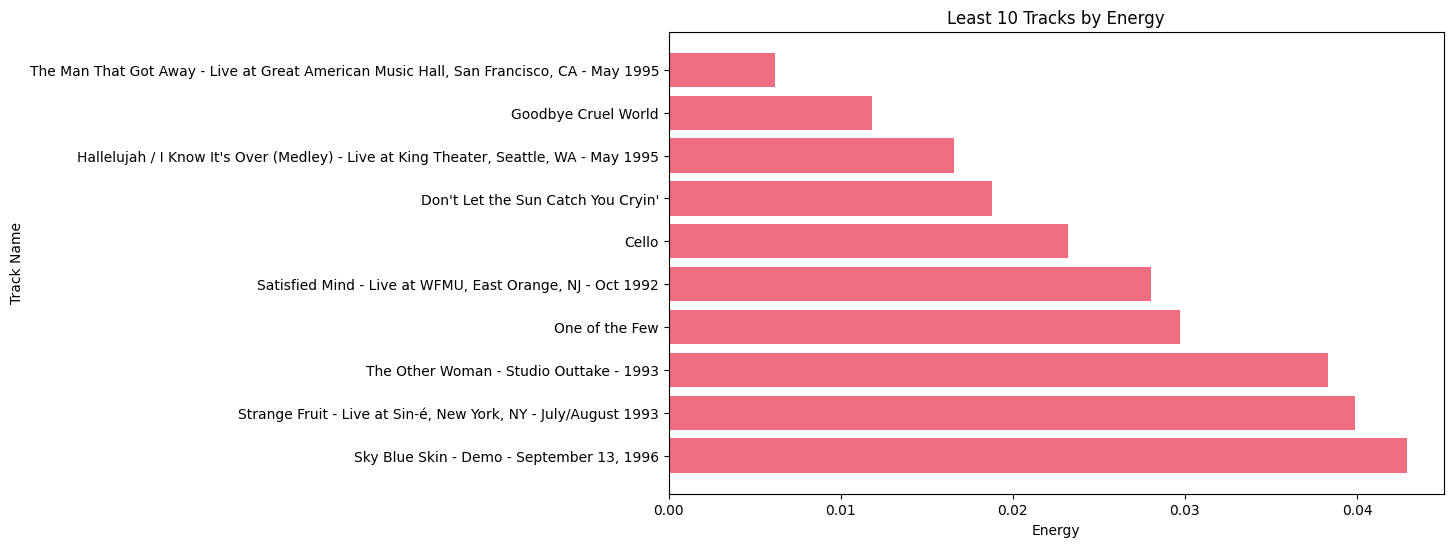

The Man That Got Away - Live at Great American Music Hall, San Francisco, CA - May 1995 by Jeff Buckley - Energy: 0.00617
Goodbye Cruel World by Pink Floyd - Energy: 0.0118
Hallelujah / I Know It's Over (Medley) - Live at King Theater, Seattle, WA - May 1995 by Jeff Buckley - Energy: 0.0166
Don't Let the Sun Catch You Cryin' by Jeff Buckley - Energy: 0.0188
Cello by Slowdive - Energy: 0.0232
Satisfied Mind - Live at WFMU, East Orange, NJ - Oct 1992 by Jeff Buckley - Energy: 0.028
One of the Few by Pink Floyd - Energy: 0.0297
The Other Woman - Studio Outtake - 1993 by Jeff Buckley - Energy: 0.0383
Strange Fruit - Live at Sin-é, New York, NY - July/August 1993 by Jeff Buckley - Energy: 0.0399
Sky Blue Skin - Demo - September 13, 1996 by Jeff Buckley - Energy: 0.0429


In [32]:
plot_least_tracks_by_feature('Energy')

#### Top and Least Tracks by Instrumentalness


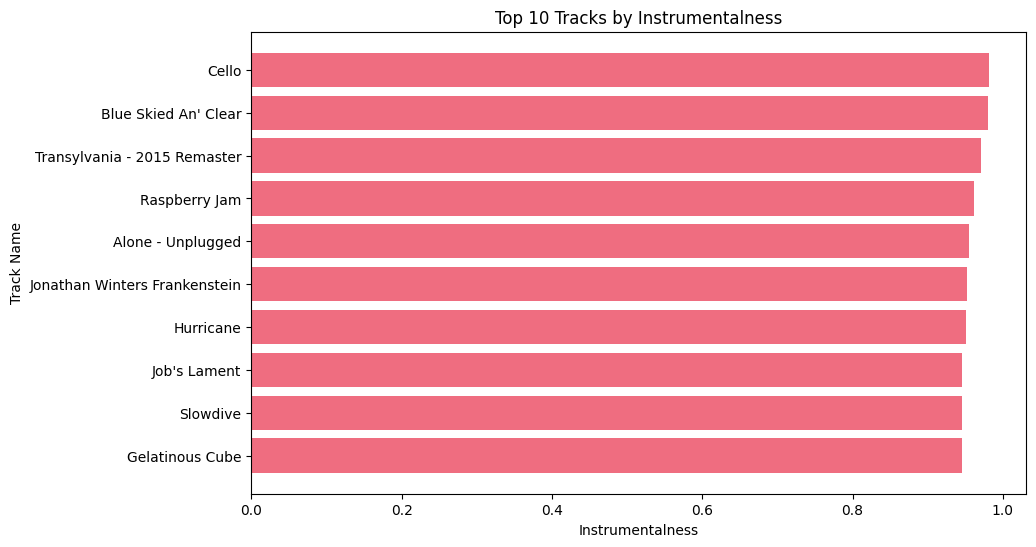

Cello by Slowdive - Instrumentalness: 0.982
Blue Skied An' Clear by Slowdive - Instrumentalness: 0.98
Transylvania - 2015 Remaster by Iron Maiden - Instrumentalness: 0.971
Raspberry Jam by Allah-Las - Instrumentalness: 0.962
Alone - Unplugged by sayk_ - Instrumentalness: 0.955
Jonathan Winters Frankenstein by Man Or Astro-Man? - Instrumentalness: 0.952
Hurricane by Kyuss - Instrumentalness: 0.951
Job's Lament by Godspeed You! Black Emperor - Instrumentalness: 0.946
Slowdive by Slowdive - Instrumentalness: 0.946
Gelatinous Cube by Thee Oh Sees - Instrumentalness: 0.946


In [33]:
plot_top_tracks_by_feature('Instrumentalness')

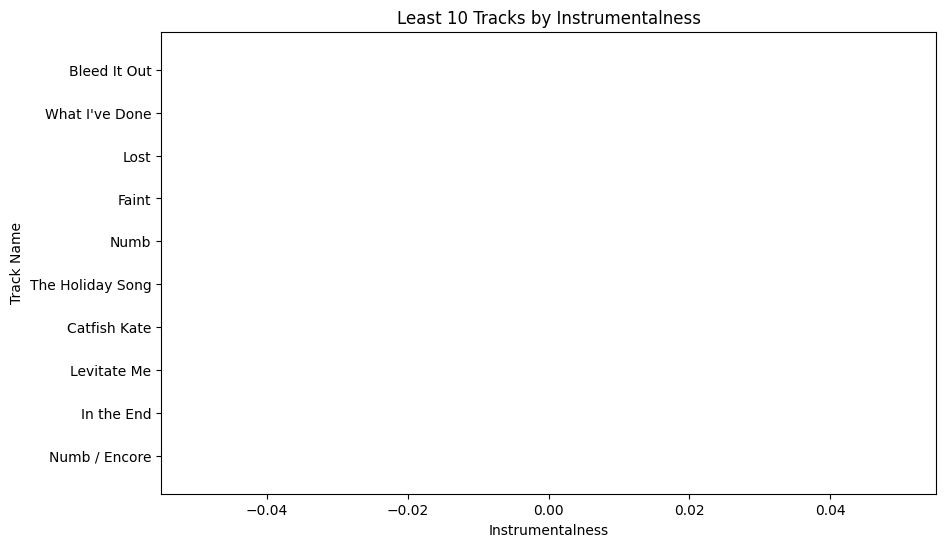

Bleed It Out by Linkin Park - Instrumentalness: 0.0
What I've Done by Linkin Park - Instrumentalness: 0.0
Lost by Linkin Park - Instrumentalness: 0.0
Faint by Linkin Park - Instrumentalness: 0.0
Numb by Linkin Park - Instrumentalness: 0.0
The Holiday Song by Pixies - Instrumentalness: 0.0
Catfish Kate by Pixies - Instrumentalness: 0.0
Levitate Me by Pixies - Instrumentalness: 0.0
In the End by Linkin Park - Instrumentalness: 0.0
Numb / Encore by JAY-Z - Instrumentalness: 0.0


In [34]:
plot_least_tracks_by_feature('Instrumentalness')

#### Top and Least Tracks by Liveness

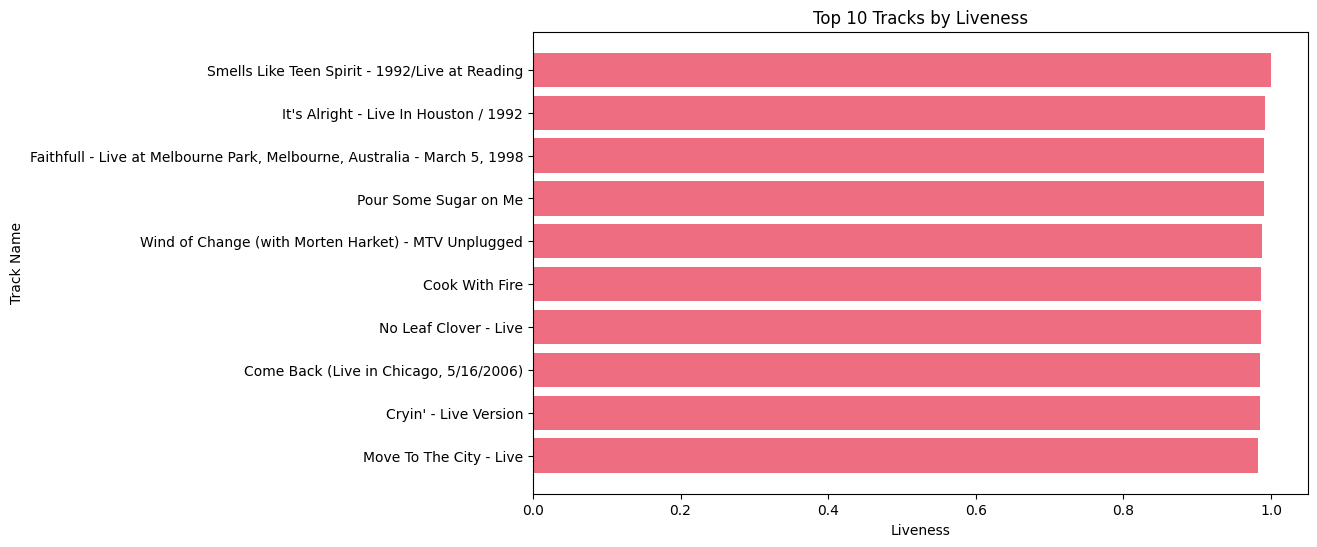

Smells Like Teen Spirit - 1992/Live at Reading by Nirvana - Liveness: 1.0
It's Alright - Live In Houston / 1992 by Guns N' Roses - Liveness: 0.992
Faithfull - Live at Melbourne Park, Melbourne, Australia - March 5, 1998 by Pearl Jam - Liveness: 0.99
Pour Some Sugar on Me by Def Leppard - Liveness: 0.99
Wind of Change (with Morten Harket) - MTV Unplugged by Scorpions - Liveness: 0.988
Cook With Fire by Heart - Liveness: 0.987
No Leaf Clover - Live by Metallica - Liveness: 0.986
Come Back (Live in Chicago, 5/16/2006) by Pearl Jam - Liveness: 0.985
Cryin' - Live Version by Aerosmith - Liveness: 0.985
Move To The City - Live by Guns N' Roses - Liveness: 0.983


In [35]:
plot_top_tracks_by_feature('Liveness')

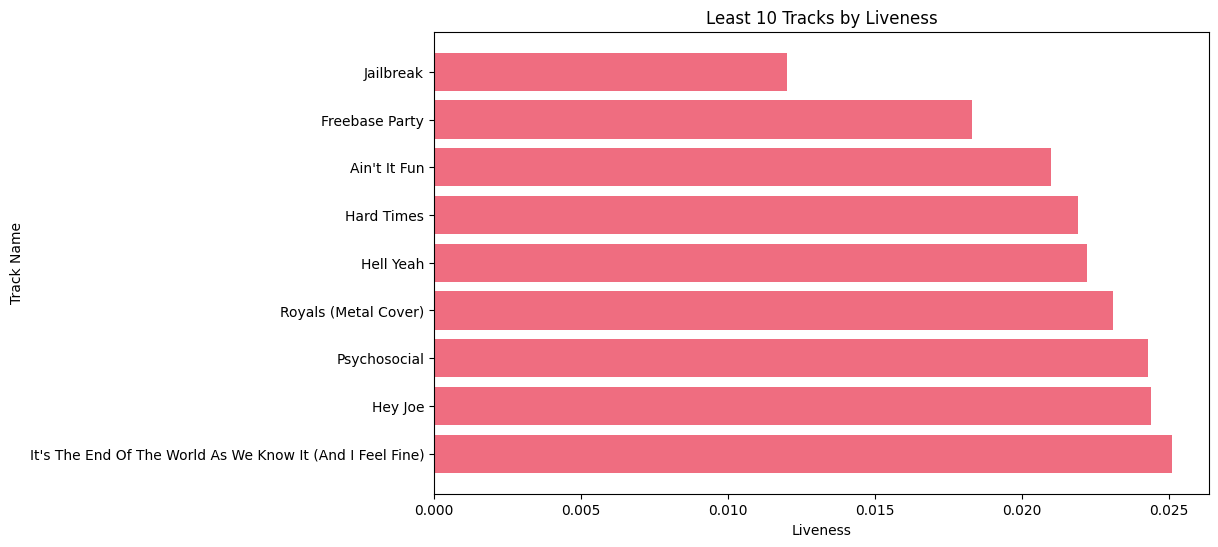

Jailbreak by AC/DC - Liveness: 0.012
Freebase Party by Counterfist - Liveness: 0.0183
Ain't It Fun by Paramore - Liveness: 0.021
Hard Times by Paramore - Liveness: 0.0219
Hell Yeah by Rev Theory - Liveness: 0.0222
Royals (Metal Cover) by Leo - Liveness: 0.0231
Psychosocial by Slipknot - Liveness: 0.0243
Psychosocial by Slipknot - Liveness: 0.0243
Hey Joe by Jimi Hendrix - Liveness: 0.0244
It's The End Of The World As We Know It (And I Feel Fine) by R.E.M. - Liveness: 0.0251


In [36]:
plot_least_tracks_by_feature('Liveness')

#### Top and Least Tracks by Loudness

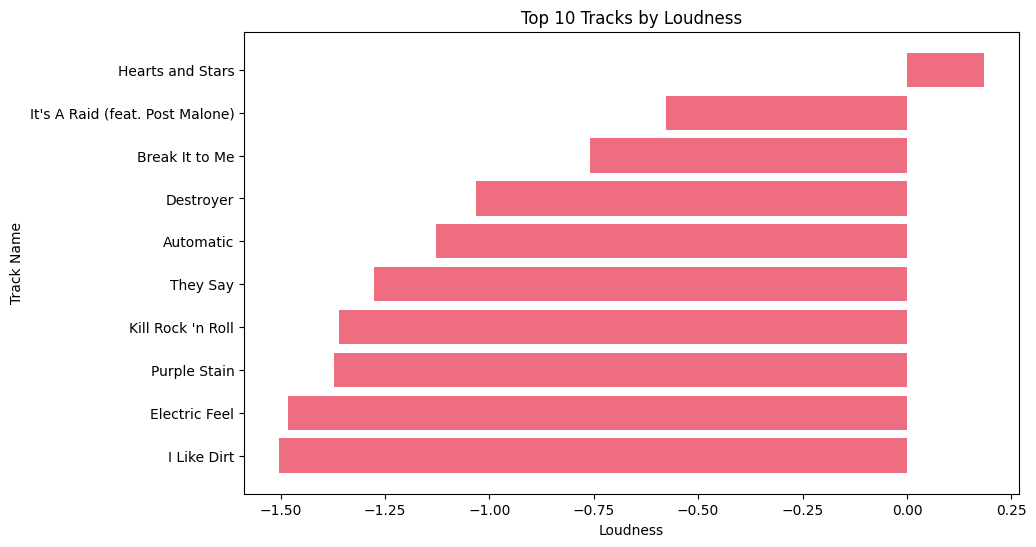

Hearts and Stars by Cage9 - Loudness: 0.184
It's A Raid (feat. Post Malone) by Ozzy Osbourne - Loudness: -0.578
Break It to Me by Muse - Loudness: -0.759
Destroyer by Static-X - Loudness: -1.032
Automatic by Angels & Airwaves - Loudness: -1.127
They Say by Daron Malakian and Scars On Broadway - Loudness: -1.275
Kill Rock 'n Roll by System Of A Down - Loudness: -1.359
Purple Stain by Red Hot Chili Peppers - Loudness: -1.372
Electric Feel by Turbowolf - Loudness: -1.481
I Like Dirt by Red Hot Chili Peppers - Loudness: -1.503


In [37]:
plot_top_tracks_by_feature('Loudness')

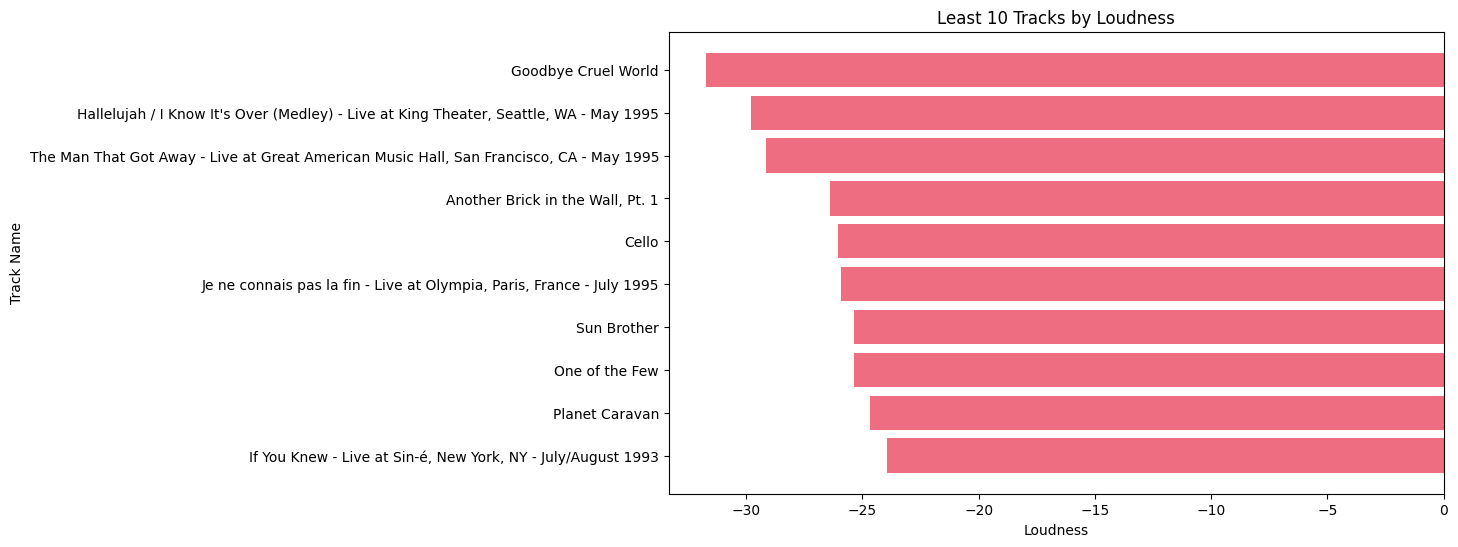

Goodbye Cruel World by Pink Floyd - Loudness: -31.734
Hallelujah / I Know It's Over (Medley) - Live at King Theater, Seattle, WA - May 1995 by Jeff Buckley - Loudness: -29.782
The Man That Got Away - Live at Great American Music Hall, San Francisco, CA - May 1995 by Jeff Buckley - Loudness: -29.148
Another Brick in the Wall, Pt. 1 by Pink Floyd - Loudness: -26.398
Cello by Slowdive - Loudness: -26.053
Je ne connais pas la fin - Live at Olympia, Paris, France - July 1995 by Jeff Buckley - Loudness: -25.914
Sun Brother by Brant Bjork - Loudness: -25.355
One of the Few by Pink Floyd - Loudness: -25.35
Planet Caravan by Black Sabbath - Loudness: -24.68
If You Knew - Live at Sin-é, New York, NY - July/August 1993 by Jeff Buckley - Loudness: -23.926


In [38]:
plot_least_tracks_by_feature('Loudness')

#### Top and Least Tracks by Speechiness
 

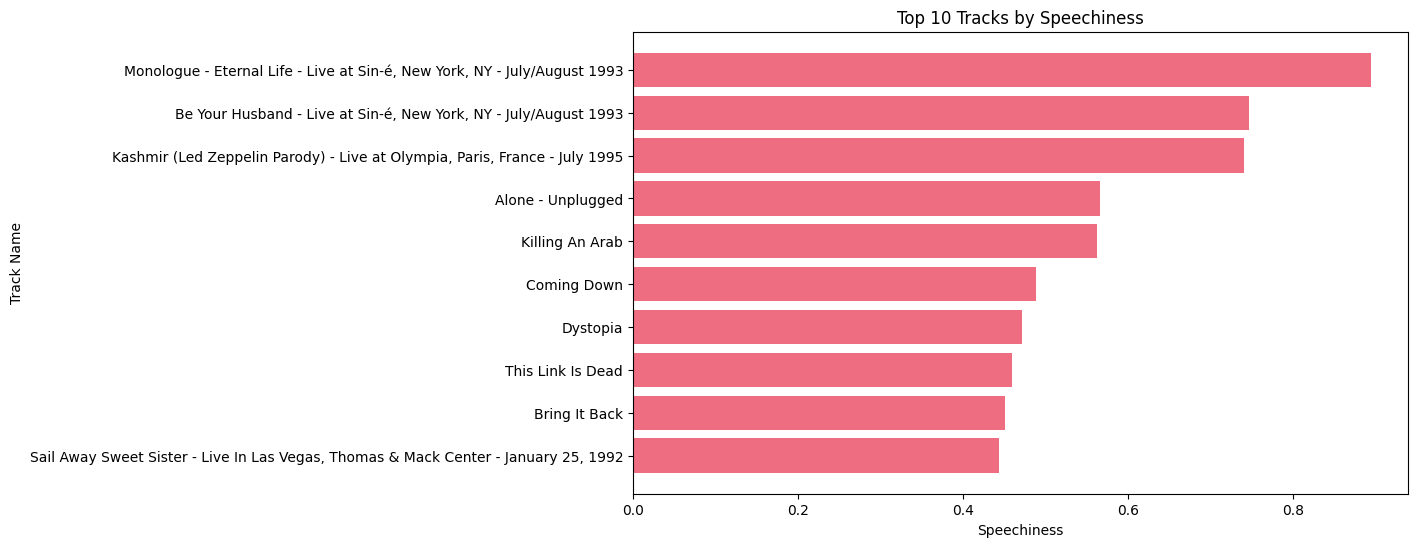

Monologue - Eternal Life - Live at Sin-é, New York, NY - July/August 1993 by Jeff Buckley - Speechiness: 0.894
Be Your Husband - Live at Sin-é, New York, NY - July/August 1993 by Jeff Buckley - Speechiness: 0.746
Kashmir (Led Zeppelin Parody) - Live at Olympia, Paris, France - July 1995 by Jeff Buckley - Speechiness: 0.74
Alone - Unplugged by sayk_ - Speechiness: 0.566
Killing An Arab by The Cure - Speechiness: 0.562
Coming Down by Five Finger Death Punch - Speechiness: 0.488
Dystopia by Megadeth - Speechiness: 0.471
This Link Is Dead by Deftones - Speechiness: 0.459
Bring It Back by Limp Bizkit - Speechiness: 0.451
Sail Away Sweet Sister - Live In Las Vegas, Thomas & Mack Center - January 25, 1992 by Guns N' Roses - Speechiness: 0.443


In [39]:
plot_top_tracks_by_feature('Speechiness')

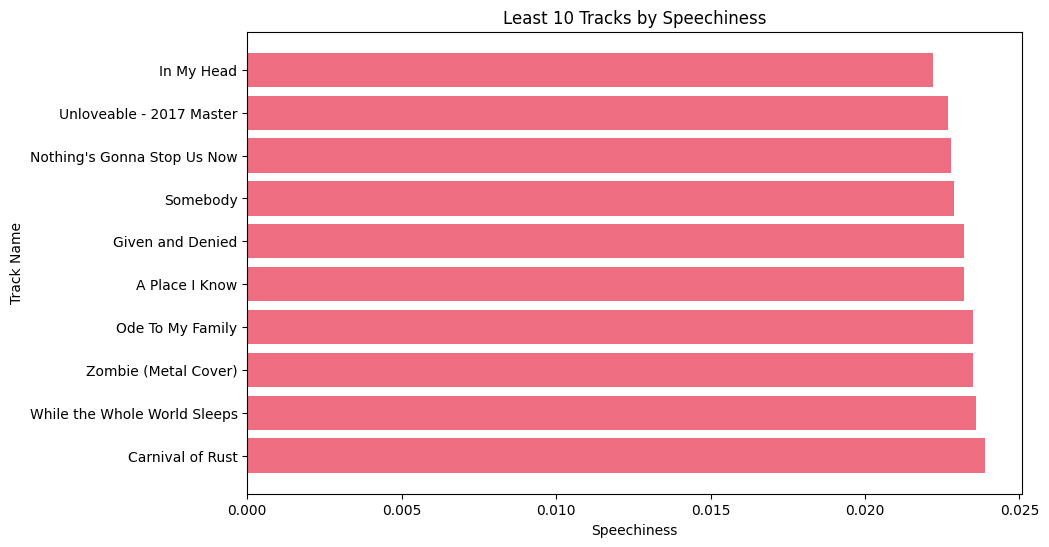

In My Head by The Night Café - Speechiness: 0.0222
Unloveable - 2017 Master by The Smiths - Speechiness: 0.0227
Nothing's Gonna Stop Us Now by Starship - Speechiness: 0.0228
Somebody by Brant Bjork - Speechiness: 0.0229
Given and Denied by Poets of the Fall - Speechiness: 0.0232
A Place I Know by The Cranberries - Speechiness: 0.0232
Ode To My Family by The Cranberries - Speechiness: 0.0235
Zombie (Metal Cover) by Leo - Speechiness: 0.0235
While the Whole World Sleeps by Samantha Henson - Speechiness: 0.0236
Carnival of Rust by Poets of the Fall - Speechiness: 0.0239


In [40]:
plot_least_tracks_by_feature('Speechiness')

#### Top and Least Tracks by Valence


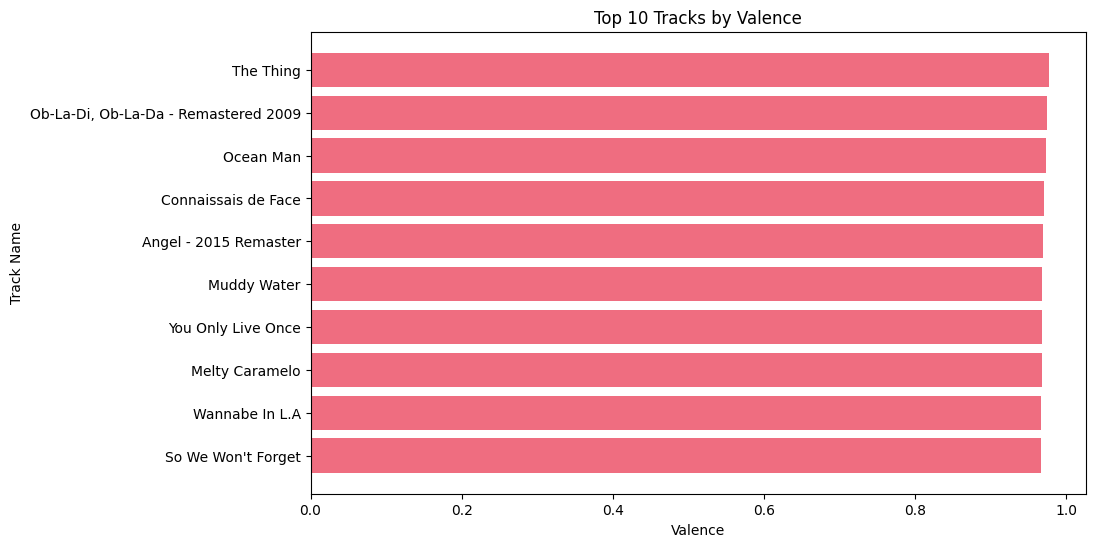

The Thing by Pixies - Valence: 0.977
Ob-La-Di, Ob-La-Da - Remastered 2009 by The Beatles - Valence: 0.975
Ocean Man by Ween - Valence: 0.973
Connaissais de Face by Khruangbin - Valence: 0.971
Angel - 2015 Remaster by Fleetwood Mac - Valence: 0.97
Muddy Water by King Gizzard & The Lizard Wizard - Valence: 0.968
You Only Live Once by The Strokes - Valence: 0.968
Melty Caramelo by Divino Niño - Valence: 0.968
Wannabe In L.A by Eagles Of Death Metal - Valence: 0.967
So We Won't Forget by Khruangbin - Valence: 0.967


In [41]:
plot_top_tracks_by_feature('Valence')

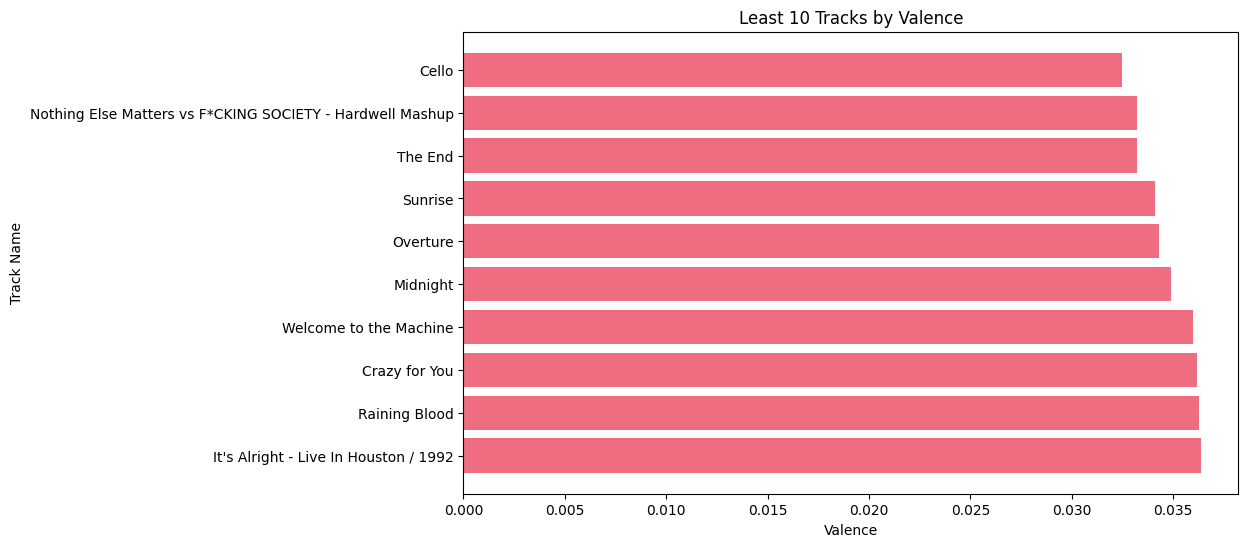

Cello by Slowdive - Valence: 0.0325
Nothing Else Matters vs F*CKING SOCIETY - Hardwell Mashup by Hardwell - Valence: 0.0332
The End by The Doors - Valence: 0.0332
Sunrise by Coldplay - Valence: 0.0341
Overture by Evanescence - Valence: 0.0343
Midnight by Coldplay - Valence: 0.0349
Welcome to the Machine by Pink Floyd - Valence: 0.036
Crazy for You by Slowdive - Valence: 0.0362
Raining Blood by Slayer - Valence: 0.0363
It's Alright - Live In Houston / 1992 by Guns N' Roses - Valence: 0.0364


In [42]:
plot_least_tracks_by_feature('Valence')

# Song Recommendation

In [43]:
vector=danalyze.to_numpy()

In [44]:
def get_song_vector(track):
        '''Get the song analysis vector of giving track
        '''
        CLIENT_ID="29c043d842174e4ebc9fb6916ff5b615"
        CLIENT_SECRET="0c28951b7456413fb2438cc462451a6b"
        client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
        sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)
      
        track_id= search_for_track(token,track).get('uri').split(':')[2]
        artist_name=search_for_track(token,track).get('artists')[0].get('name')
        
        features=['acousticness','danceability','energy','instrumentalness','liveness'
                  ,'loudness','mode','speechiness','tempo','valence']
        
        artist_dic=search_for_artist(token,f'{artist_name}')
        
        result=np.zeros(10)
        track_analyze= sp.audio_features(f'{track_id}')[0]
        
        k=0
        for feature in features:
            result[k]=track_analyze.get(feature)
            k+=1
        result[0]=np.log(result[0]);result[4]=np.log(result[4]);result[7]=1/result[7];result[8]=result[8]**(0.5)
        result=np.delete(result,6,0)
        result=np.delete(result,3,0)
    
        return result


In [45]:
def cosine_similarity(vector1, vector2):
    """
    Compute the cosine similarity between two vectors.
    """
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    return similarity

def recommend_similar_songs(song_name, vector, ids, k=5):
    """
    Recommend similar songs from different artists than given one based on cosine similarity between vectors.
    """
    my_vector=get_song_vector(song_name)
    track_name= search_for_track(token,song_name).get('name')
    track_artist=search_for_track(token,song_name).get('artists')[0].get('name')
    print('Track name: ',track_name)
    print('Artist name: ',track_artist)
    

    results = []
    for i, song_vector in enumerate(vector):
        cur.execute(f"SELECT track_name FROM track_rock WHERE id='{ids[i]}';")
        name=cur.fetchone()[0]
        cur.execute(f"SELECT artist_name FROM track_rock INNER JOIN artist_rock ON artist_rock.id=track_rock.artist_id WHERE track_rock.id='{ids[i]}';")
        artist=cur.fetchone()[0]
        if (song_vector == my_vector).sum()!=9 and track_artist!=artist:
            similarity = cosine_similarity(my_vector, song_vector)
            results.append((name, artist, similarity))
    
    # Sort results by similarity in descending order
    results.sort(key=lambda x: x[2], reverse=True)

    # Get top k recommendations
    top_recommendations = [(track_name, artist) for track_name, artist, _ in results[:k]]
    return top_recommendations


In [46]:
song_name = "Stairway to Heaven"
similar_songs = recommend_similar_songs(song_name, vector, ids)
print("Top 5 similar songs:")
for i, (track_name, artist) in enumerate(similar_songs, start=1):
    print(f"{i}. Track Name: {track_name}")
    print(f"   Artist: {artist}")

Track name:  Stairway to Heaven - Remaster
Artist name:  Led Zeppelin
Top 5 similar songs:
1. Track Name: Infinity
   Artist: The xx
2. Track Name: Something In The Way
   Artist: Nirvana
3. Track Name: Am I Inside
   Artist: Alice In Chains
4. Track Name: The Surrender
   Artist: Limp Bizkit
5. Track Name: Off He Goes
   Artist: Pearl Jam


In [47]:
song_name = "Send me an angle"
similar_songs = recommend_similar_songs(song_name, vector, ids)
print("Top 5 similar songs:")
for i, (track_name, artist) in enumerate(similar_songs, start=1):
    print(f"{i}. Track Name: {track_name}")
    print(f"   Artist: {artist}")

Track name:  Send Me An Angel
Artist name:  Scorpions
Top 5 similar songs:
1. Track Name: Dumb
   Artist: Nirvana
2. Track Name: Southern Cross - 2005 Remaster
   Artist: Crosby, Stills & Nash
3. Track Name: Morning Theft
   Artist: Jeff Buckley
4. Track Name: On the Turning Away
   Artist: Pink Floyd
5. Track Name: Havalina
   Artist: Pixies


In [48]:
song_name = "Never Had No One Ever"
similar_songs = recommend_similar_songs(song_name, vector, ids)
print("Top 5 similar songs:")
for i, (track_name, artist) in enumerate(similar_songs, start=1):
    print(f"{i}. Track Name: {track_name}")
    print(f"   Artist: {artist}")

Track name:  Never Had No One Ever - 2011 Remaster
Artist name:  The Smiths
Top 5 similar songs:
1. Track Name: Graveyard Whistling
   Artist: Nothing But Thieves
2. Track Name: Pompeii
   Artist: Bastille
3. Track Name: Kalopsia
   Artist: Queens of the Stone Age
4. Track Name: Fortunate Son
   Artist: Creedence Clearwater Revival
5. Track Name: Taciturn
   Artist: Stone Sour


In [49]:
song_name = "Tears in Heaven"
similar_songs = recommend_similar_songs(song_name, vector, ids)
print("Top 5 similar songs:")
for i, (track_name, artist) in enumerate(similar_songs, start=1):
    print(f"{i}. Track Name: {track_name}")
    print(f"   Artist: {artist}")

Track name:  Tears in Heaven
Artist name:  Eric Clapton
Top 5 similar songs:
1. Track Name: Unintended
   Artist: Muse
2. Track Name: Whale & Wasp
   Artist: Alice In Chains
3. Track Name: A Message to Myself
   Artist: The Night Café
4. Track Name: Phantasmagoria Blues
   Artist: Mark Lanegan
5. Track Name: Hey There Delilah
   Artist: Plain White T's


In [50]:
song_name = "Deli mor ve ötesi"
similar_songs = recommend_similar_songs(song_name, vector, ids)
print("Top 5 similar songs:")
for i, (track_name, artist) in enumerate(similar_songs, start=1):
    print(f"{i}. Track Name: {track_name}")
    print(f"   Artist: {artist}")

Track name:  Deli
Artist name:  mor ve ötesi
Top 5 similar songs:
1. Track Name: Still into You
   Artist: Paramore
2. Track Name: Remember Everything
   Artist: Five Finger Death Punch
3. Track Name: Dear Dictator
   Artist: Saint Motel
4. Track Name: Dead To Me
   Artist: Hinder
5. Track Name: I Don't Care (feat. Adam Gontier)
   Artist: Apocalyptica


In [51]:
song_name = "Dibine Kadar"
similar_songs = recommend_similar_songs(song_name, vector, ids)
print("Top 5 similar songs:")
for i, (track_name, artist) in enumerate(similar_songs, start=1):
    print(f"{i}. Track Name: {track_name}")
    print(f"   Artist: {artist}")

Track name:  Dibine Kadar
Artist name:  Duman
Top 5 similar songs:
1. Track Name: Passenger
   Artist: Deftones
2. Track Name: Horizon (From "Dying Light")
   Artist: Johari
3. Track Name: Time to Waste
   Artist: Alkaline Trio
4. Track Name: Push
   Artist: The Cure
5. Track Name: Time is Running Out
   Artist: Muse
